In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from textblob import TextBlob

In [6]:
# read data

data = pd.read_csv("/Users/Downloads/training_set30 .csv", sep = ',')
data

,Unnamed: 0,id,title,author,text,label
0,16285,16284,The Voting Dead: CBS4 Investigation Exposes Vo...,Jenna Leigh Richardson,A CBS Denver voter fraud investigation has exp...,1
1,16573,16572,How to Suppress the Apology Reflex - The New Y...,Audrey S. Lee,Editors’ note: Here’s one of our favorite stor...,0
2,1001,1000,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,Breitbart News,On the Wednesday edition of Breitbart News Dai...,0
3,13129,13128,Found this nugget in Podesta files Fastwalkers...,seentoomuch,Found this nugget in Podesta files Fastwalkers...,1
4,6348,6347,NaN,ctwatcher✓ᵛᵉʳᶦᶠᶦᵉᵈ,Beard or no beard I can spot them a mile away....,1
...,...,...,...,...,...,...
14995,11065,11064,"Stephen Bannon, a Rookie Campaign Chief Who ‘L...",Michael Barbaro and Michael M. Grynbaum,As the American financial system collapsed in ...,0
14996,9474,9473,New York Times: Apologist for Power,Consortiumnews.com,New York Times: Apologist for Power November 7...,1
14997,1709,1708,Alabama Makes It Illegal to Remove Confederate...,Ryan Saavedra,The new law attempts to preserve history by ma...,0
14998,1487,1486,SAY WHAT? Chicago Tribune calls on Democrats t...,BareNakedIslam,Notify me of follow-up comments by email. Noti...,1


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15000 non-null  int64 
 1   id          15000 non-null  int64 
 2   title       14609 non-null  object
 3   author      13561 non-null  object
 4   text        14976 non-null  object
 5   label       15000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 703.2+ KB


## 1. Data Preparation

In [89]:
# remove rows with nan values

data_non_null = data.dropna(how = 'any', axis = 0).reset_index()
data_non_null

,index,Unnamed: 0,id,title,author,text,label
0,0,16285,16284,The Voting Dead: CBS4 Investigation Exposes Vo...,Jenna Leigh Richardson,A CBS Denver voter fraud investigation has exp...,1
1,1,16573,16572,How to Suppress the Apology Reflex - The New Y...,Audrey S. Lee,Editors’ note: Here’s one of our favorite stor...,0
2,2,1001,1000,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,Breitbart News,On the Wednesday edition of Breitbart News Dai...,0
3,3,13129,13128,Found this nugget in Podesta files Fastwalkers...,seentoomuch,Found this nugget in Podesta files Fastwalkers...,1
4,5,2187,2186,Despite Democrat Obstruction U.S. Senate Confi...,Warner Todd Huston,"On Monday evening, Kansas Republican Mike Pomp...",0
...,...,...,...,...,...,...,...
13165,14995,11065,11064,"Stephen Bannon, a Rookie Campaign Chief Who ‘L...",Michael Barbaro and Michael M. Grynbaum,As the American financial system collapsed in ...,0
13166,14996,9474,9473,New York Times: Apologist for Power,Consortiumnews.com,New York Times: Apologist for Power November 7...,1
13167,14997,1709,1708,Alabama Makes It Illegal to Remove Confederate...,Ryan Saavedra,The new law attempts to preserve history by ma...,0
13168,14998,1487,1486,SAY WHAT? Chicago Tribune calls on Democrats t...,BareNakedIslam,Notify me of follow-up comments by email. Noti...,1


In [191]:
# calculate no of news article and labels

label_plot = pd.DataFrame({'label_1': [np.sum(data_non_null['label'] == 1)], 'label_0': [np.sum(data_non_null['label'] == 0)]})
data_len = len(data_non_null)

print('Number of news article:', data_len)
print('Number of articles labelled as unreliable (label 1):', label_plot.iloc[0, 0])
print('Number of articles labelled as reliable (label 0):', label_plot.iloc[0, 1])

Number of news article: 13170
Number of articles labelled as unreliable (label 1): 5764
Number of articles labelled as reliable (label 0): 7406


In [92]:
# calculate text length

data_non_null['text_length'] = data_non_null['text'].apply(len)
data_non_null.head()

,index,Unnamed: 0,id,title,author,text,label,text_length
0,0,16285,16284,The Voting Dead: CBS4 Investigation Exposes Vo...,Jenna Leigh Richardson,A CBS Denver voter fraud investigation has exp...,1,1219
1,1,16573,16572,How to Suppress the Apology Reflex - The New Y...,Audrey S. Lee,Editors’ note: Here’s one of our favorite stor...,0,4739
2,2,1001,1000,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,Breitbart News,On the Wednesday edition of Breitbart News Dai...,0,1211
3,3,13129,13128,Found this nugget in Podesta files Fastwalkers...,seentoomuch,Found this nugget in Podesta files Fastwalkers...,1,2758
4,5,2187,2186,Despite Democrat Obstruction U.S. Senate Confi...,Warner Todd Huston,"On Monday evening, Kansas Republican Mike Pomp...",0,1708


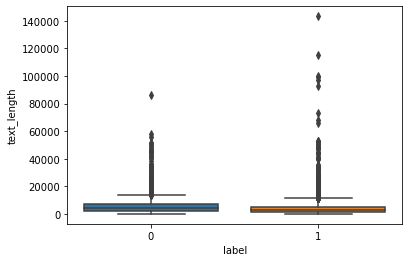

In [93]:
# visualize the distribution of text length

sns.boxplot(x = 'label', y = 'text_length', data = data_non_null)
plt.show()

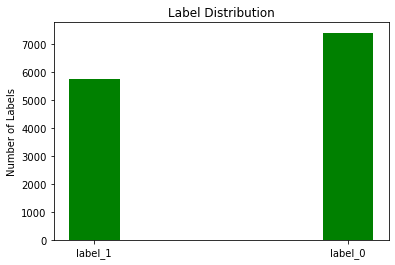

In [141]:
# visualize the label distribution

x, y = label_plot.columns, label_plot.iloc[0]
plt.bar(x, y, width = 0.2, color = 'green')
plt.title('Label Distribution')
plt.ylabel('Number of Labels')
plt.show()

In [185]:
# call the stopword list

stop_list = nltk.corpus.stopwords.words("english")

# define a function to clean texts

def cleaning(text):
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text_space = text.str.replace(regex_pat, ' ')
    
    # removal of punctuations and numbers
    punc_remove = text_space.str.replace("[^a-zA-Z]", " ")
    
    # remove whitespace with a single space
    newtext = punc_remove.str.replace(r'\s+', ' ')
    
    # remove leading and trailing whitespace
    newtext = newtext.str.replace(r'^\s+|\s+?$','')
    
    # replace normal numbers with numbr
    newtext = newtext.str.replace(r'\d+(\.\d+)?','numbr')
    
    # removal of capitalization
    text_lower = newtext.str.lower()
    
    # tokenizing
    tokenized_text = text_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_text = tokenized_text.apply(lambda x: [item for item in x if item not in stop_list])
    
    for i in range(len(tokenized_text)):
        tokenized_text[i] = ' '.join(tokenized_text[i])
        text_final = tokenized_text
    
    return text_final

# clean text, title, and author columns

text_clean = cleaning(data_non_null['text'])
title_clean = cleaning(data_non_null['title'])
author_clean = cleaning(data_non_null['author'])

In [186]:
# combine combine them with the original dataset

data_non_null['text_clean'] = text_clean
data_non_null['title_clean'] = title_clean
data_non_null['author_clean'] = author_clean

In [187]:
print(data_non_null[['text', 'text_clean']].head(5))

                                                text  \
0  A CBS Denver voter fraud investigation has exp...   
1  Editors’ note: Here’s one of our favorite stor...   
2  On the Wednesday edition of Breitbart News Dai...   
3  Found this nugget in Podesta files Fastwalkers...   
4  On Monday evening, Kansas Republican Mike Pomp...   

                                          text_clean  
0  cbs denver voter fraud investigation exposed d...  
1  editors note one favorite stories archives fea...  
2  wednesday edition breitbart news daily broadca...  
3  found nugget podesta files fastwalkers dsp pro...  
4  monday evening kansas republican mike pompeo c...  


In [188]:
print(data_non_null[['title', 'title_clean']].head(5))

                                               title  \
0  The Voting Dead: CBS4 Investigation Exposes Vo...   
1  How to Suppress the Apology Reflex - The New Y...   
2  Breitbart News Daily: Gorsuch for SCOTUS - Bre...   
3  Found this nugget in Podesta files Fastwalkers...   
4  Despite Democrat Obstruction U.S. Senate Confi...   

                                         title_clean  
0  voting dead cbs investigation exposes voter fr...  
1             suppress apology reflex new york times  
2      breitbart news daily gorsuch scotus breitbart  
3  found nugget podesta files fastwalkers dsp pro...  
4  despite democrat obstruction u senate confirms...  


In [200]:
print(data_non_null[['author', 'author_clean']].head(5))

                   author            author_clean
0  Jenna Leigh Richardson  jenna leigh richardson
1           Audrey S. Lee              audrey lee
2          Breitbart News          breitbart news
3             seentoomuch             seentoomuch
4      Warner Todd Huston      warner todd huston


## 2. Data Visualization

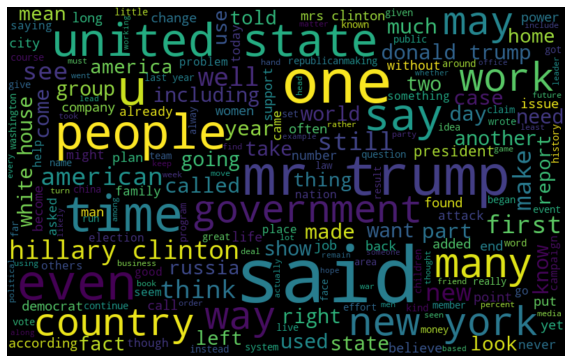

In [119]:
# visualize the most frequent words in text

all_words = ' '.join([text for text in data_non_null['text_clean']])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

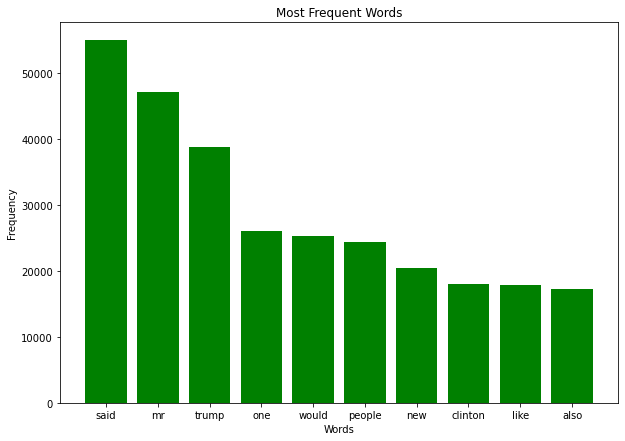

In [144]:
# visualize most frequent words

freq = pd.Series(' '.join(data_non_null['text_clean']).split()).value_counts()[:10]
plt.figure(figsize = (10, 7))
plt.bar(freq.index, freq, color = 'green')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

In [202]:
# overall tweet sentiment

overall_sentiment = TextBlob(str(data_non_null['text_clean'])).sentiment[0]
print("The overall sentiment of all tweets is: " + str(overall_sentiment), "1: positive", "-1: negative", sep = "\n")

The overall sentiment of all tweets is: 0.010909090909090901
1: positive
-1: negative


## 3. Modelling

In [121]:
# drop unnecessary columns

data_final = data_non_null.drop(['index', 'Unnamed: 0', 'title', 'author', 'text'], axis = 1)
data_final

,id,label,text_length,text_clean,title_clean,author_clean
0,16284,1,1219,cbs denver voter fraud investigation exposed d...,voting dead cbs investigation exposes voter fr...,jenna leigh richardson
1,16572,0,4739,editors note one favorite stories archives fea...,suppress apology reflex new york times,audrey lee
2,1000,0,1211,wednesday edition breitbart news daily broadca...,breitbart news daily gorsuch scotus breitbart,breitbart news
3,13128,1,2758,found nugget podesta files fastwalkers dsp pro...,found nugget podesta files fastwalkers dsp pro...,seentoomuch
4,2186,0,1708,monday evening kansas republican mike pompeo c...,despite democrat obstruction u senate confirms...,warner todd huston
...,...,...,...,...,...,...
13165,11064,0,8319,american financial system collapsed fall steph...,stephen bannon rookie campaign chief loves fig...,michael barbaro michael grynbaum
13166,9473,1,26210,new york times apologist power november specia...,new york times apologist power,consortiumnews com
13167,1708,0,2794,new law attempts preserve history making illeg...,alabama makes illegal remove confederate monum...,ryan saavedra
13168,1486,1,443,notify follow comments email notify new posts ...,say chicago tribune calls democrats force clin...,barenakedislam


In [125]:
# convert the tweets into statistical numbers

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.75, min_df = 5, max_features = data_len)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(data_final['text_clean'] )
tfidf

<13170x13170 sparse matrix of type '<class 'numpy.float64'>'
	with 3497512 stored elements in Compressed Sparse Row format>

In [135]:
# data split

X = tfidf
y = data_final['label']
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [138]:
# Logistic Regression 

model_lr = LogisticRegression(C = 2, max_iter = 500).fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)
report_lr = classification_report(y_test, y_pred_lr)

print(report_lr)
acc_lr = accuracy_score(y_test, y_pred_lr)
label_lr = "Logistic Regression"
print(label_lr)
print('Accuracy: ', acc_lr)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1457
           1       0.95      0.96      0.95      1177

    accuracy                           0.96      2634
   macro avg       0.96      0.96      0.96      2634
weighted avg       0.96      0.96      0.96      2634

Logistic Regression
Accuracy:  0.9593773728170083


In [147]:
# Decision Tree

model_dt = tree.DecisionTreeClassifier().fit(X_train_tfidf, y_train)
y_pred_dt = model_dt.predict(X_test_tfidf)
report_dt = classification_report(y_test, y_pred_dt)

print(report_dt)
acc_dt = accuracy_score(y_test, y_pred_dt)
label_dt = 'Decision Tree'
print(label_dt)
print('Accuracy: ', acc_dt)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1457
           1       0.86      0.88      0.87      1177

    accuracy                           0.88      2634
   macro avg       0.88      0.88      0.88      2634
weighted avg       0.88      0.88      0.88      2634

Decision Tree
Accuracy:  0.8819286256643888


In [148]:
# kNN

model_knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', p = 1).fit(X_train_tfidf, y_train)
y_pred_knn = model_knn.predict(X_test_tfidf)
report_knn = classification_report(y_test, y_pred_knn)

print(report_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)
label_knn = 'K-nearest Neighbors'
print(label_knn)
print('Accuracy: ', acc_knn)

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1457
           1       0.45      1.00      0.62      1177

    accuracy                           0.45      2634
   macro avg       0.72      0.50      0.32      2634
weighted avg       0.75      0.45      0.28      2634

K-nearest Neighbors
Accuracy:  0.4506454062262718


In [149]:
# Random Forest

model_rf = RandomForestClassifier(n_estimators = 200).fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)
report_rf = classification_report(y_test, y_pred_rf)

print(report_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)
label_rf = 'Random Forest'
print(label_rf)
print('Accuracy: ', acc_rf)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1457
           1       0.96      0.92      0.94      1177

    accuracy                           0.95      2634
   macro avg       0.95      0.95      0.95      2634
weighted avg       0.95      0.95      0.95      2634

Random Forest
Accuracy:  0.9483675018982536


In [150]:
# SVM

model_svm = LinearSVC().fit(X_train_tfidf, y_train)
y_pred_svm = model_svm.predict(X_test_tfidf)
report_svm = classification_report(y_test, y_pred_svm)

print(report_svm)
acc_svm = accuracy_score(y_test, y_pred_svm)
label_svm = 'SVM'
print(label_svm)
print('Accuracy: ', acc_svm)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1457
           1       0.96      0.96      0.96      1177

    accuracy                           0.96      2634
   macro avg       0.96      0.96      0.96      2634
weighted avg       0.96      0.96      0.96      2634

SVM
Accuracy:  0.9627942293090357


In [157]:
# Ridge Regression

model_ridge = RidgeClassifier().fit(X_train_tfidf, y_train)
y_pred_ridge = model_ridge.predict(X_test_tfidf)
report_ridge = classification_report(y_test, y_pred_ridge)

print(report_ridge)
acc_ridge = accuracy_score(y_test, y_pred_ridge)
label_ridge = 'Ridge Regression'
print(label_ridge)
print('Accuracy: ', acc_ridge)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1457
           1       0.95      0.96      0.95      1177

    accuracy                           0.96      2634
   macro avg       0.96      0.96      0.96      2634
weighted avg       0.96      0.96      0.96      2634

Ridge Regression
Accuracy:  0.9593773728170083


## 4. Results

In [176]:
# summary of modelling results

d0 = pd.DataFrame([label_lr, label_dt, label_knn, label_rf, label_svm, label_ridge])
d1 = pd.DataFrame([acc_lr, acc_dt, acc_knn, acc_rf, acc_svm, acc_ridge])
d2 = pd.concat([d0, d1], axis = 1)
d2.columns = ['Model', 'Accuracy']
d2 = d2.sort_values(by = ['Accuracy'], ascending = False)

display(d2)
print('The best model is', d2.iloc[0, 0])

,Model,Accuracy
4,SVM,0.962794
0,Logistic Regression,0.959377
5,Ridge Regression,0.959377
3,Random Forest,0.948368
1,Decision Tree,0.881929
2,K-nearest Neighbors,0.450645


The best model is SVM


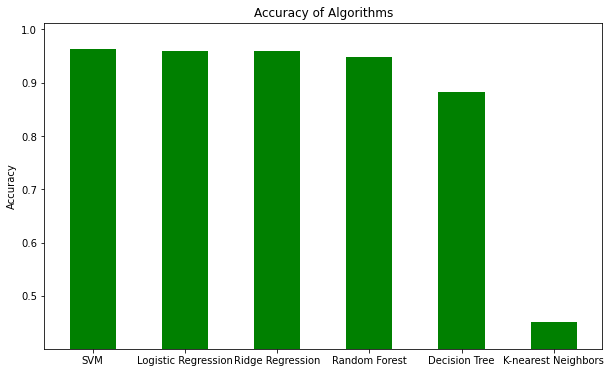

In [165]:
# plot the graph of accuracy of algorithms

plt.figure(figsize = (10, 6))
plt.bar(d2['Model'], d2['Accuracy'], width = 0.5, color = 'green')
plt.title('Accuracy of Algorithms')
plt.ylabel('Accuracy')

lower_bound = d2.iloc[-1, -1] - 0.05
upper_bound = d2.iloc[0, 1] + 0.05
plt.ylim(lower_bound, upper_bound)
plt.show()

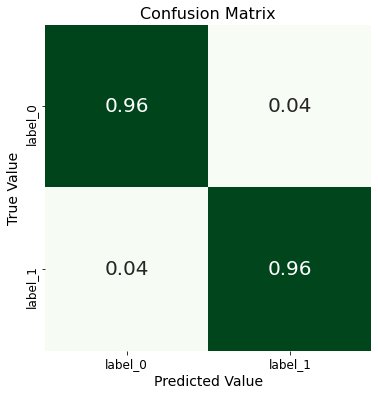

In [177]:
# visualize the confusion matrix of the most accurate algorithm

confusion_matrix_final = confusion_matrix(y_test, y_pred_lr)
matrix_proportions = np.zeros((2, 2))
for i in range(0,2):
    matrix_proportions[i, :] = confusion_matrix_final[i, :] / float(confusion_matrix_final[i, :].sum())
names = ['label_0', 'label_1']
confusion_df = pd.DataFrame(matrix_proportions, index = names, columns = names)
plt.figure(figsize = (6, 6))
sns.heatmap(confusion_df, annot = True, annot_kws = {"size": 20}, cmap = 'Greens', cbar = False, square = True,fmt = '.2f')
plt.title('Confusion Matrix', fontsize = 16)
plt.ylabel(r'True Value', fontsize = 14)
plt.xlabel(r'Predicted Value', fontsize = 14)
plt.tick_params(labelsize = 12)

## 5. Test the Best Model with Testing Dataset

In [178]:
# read testing dataset

test_data = pd.read_csv("/Users/Downloads/testing_set30 .csv", sep = ',')
test_data

,Unnamed: 0,id,title,author,text
0,4890,25689,Splash! Jerry Brown Says California’s Drought ...,Joel B. Pollak,California Gov. Jerry Brown declared Friday th...
1,3599,24398,GOP Sen Lee: ’Would Not Say No’ to SCOTUS Offe...,Jeff Poor,In an interview on Salt Lake City’s KSL’s “The...
2,2061,22860,"In a Late-Night Move, Russia Arrests a Top Eco...",Neil MacFarquhar,MOSCOW — Russians awoke to an extraordinary...
3,1314,22113,Hillary Clinton Planning Trump Russian Agent L...,The European Union Times,\r\nHillary Clinton has been caught in yet ano...
4,2658,23457,Obamacare architect: ‘The law is working as de...,Howard Portnoy,Print \r\nOn Wednesday’s broadcast of “CNN New...
...,...,...,...,...,...
3995,1848,22647,Anonymous – World War 3 is imminent 2016,Pakalert,
3996,3970,24769,Rick Perry Accuses Texas A&ampM of Disqualifyi...,Tom Ciccotta,Rick Perry has accused administrators at Texas...
3997,3408,24207,Cuba Gooding Jr. Sparks Outrage After Lifting ...,Jerome Hudson,Actor Cuba Gooding Jr. came under fire on soci...
3998,3424,24223,Diplomats Confront New Threat to Paris Climate...,Coral Davenport,"MARRAKESH, Morocco — Diplomats from around ..."


In [179]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4000 non-null   int64 
 1   id          4000 non-null   int64 
 2   title       3911 non-null   object
 3   author      3607 non-null   object
 4   text        3995 non-null   object
dtypes: int64(2), object(3)
memory usage: 156.4+ KB


In [180]:
# remove rows with nan values

test_data_non_null = test_data.dropna(how = 'any', axis = 0).reset_index()
test_data_non_null

,index,Unnamed: 0,id,title,author,text
0,0,4890,25689,Splash! Jerry Brown Says California’s Drought ...,Joel B. Pollak,California Gov. Jerry Brown declared Friday th...
1,1,3599,24398,GOP Sen Lee: ’Would Not Say No’ to SCOTUS Offe...,Jeff Poor,In an interview on Salt Lake City’s KSL’s “The...
2,2,2061,22860,"In a Late-Night Move, Russia Arrests a Top Eco...",Neil MacFarquhar,MOSCOW — Russians awoke to an extraordinary...
3,3,1314,22113,Hillary Clinton Planning Trump Russian Agent L...,The European Union Times,\r\nHillary Clinton has been caught in yet ano...
4,4,2658,23457,Obamacare architect: ‘The law is working as de...,Howard Portnoy,Print \r\nOn Wednesday’s broadcast of “CNN New...
...,...,...,...,...,...,...
3513,3995,1848,22647,Anonymous – World War 3 is imminent 2016,Pakalert,
3514,3996,3970,24769,Rick Perry Accuses Texas A&ampM of Disqualifyi...,Tom Ciccotta,Rick Perry has accused administrators at Texas...
3515,3997,3408,24207,Cuba Gooding Jr. Sparks Outrage After Lifting ...,Jerome Hudson,Actor Cuba Gooding Jr. came under fire on soci...
3516,3998,3424,24223,Diplomats Confront New Threat to Paris Climate...,Coral Davenport,"MARRAKESH, Morocco — Diplomats from around ..."


In [190]:
# clean the data and combine them with the original dataset

text_clean_test = cleaning(test_data_non_null['text'])
title_clean_test = cleaning(test_data_non_null['title'])
author_clean_test = cleaning(test_data_non_null['author'])

test_data_non_null['text_clean'] = text_clean_test
test_data_non_null['title_clean'] = title_clean_test
test_data_non_null['author_clean'] = author_clean_test

In [193]:
# drop unnecessary columns

test_data_final = test_data_non_null.drop(['index', 'Unnamed: 0', 'title', 'author', 'text'], axis = 1)
test_data_final

,id,text_clean,title_clean,author_clean
0,25689,california gov jerry brown declared friday dro...,splash jerry brown says california drought bre...,joel b pollak
1,24398,interview salt lake city ksl doug wright show ...,gop sen lee would say scotus offer breitbart,jeff poor
2,22860,moscow russians awoke extraordinary scandal tu...,late night move russia arrests top economic of...,neil macfarquhar
3,22113,hillary clinton caught yet another dirty trick...,hillary clinton planning trump russian agent l...,european union times
4,23457,print wednesday broadcast cnn newsroom mit eco...,obamacare architect law working designed needs...,howard portnoy
...,...,...,...,...
3513,22647,,anonymous world war imminent,pakalert
3514,24769,rick perry accused administrators texas disqua...,rick perry accuses texas ampm disqualifying st...,tom ciccotta
3515,24207,actor cuba gooding jr came fire social media s...,cuba gooding jr sparks outrage lifting sarah p...,jerome hudson
3516,24223,marrakesh morocco diplomats around world conve...,diplomats confront new threat paris climate pa...,coral davenport


In [194]:
# TF-IDF feature matrix
tfidf_test = tfidf_vectorizer.fit_transform(test_data_final['text_clean'] )
tfidf_test

<3518x13170 sparse matrix of type '<class 'numpy.float64'>'
	with 950540 stored elements in Compressed Sparse Row format>

In [197]:
# prediction

y_pred_svm_test = model_svm.predict(tfidf_test)
test_data_final['prediction'] = y_pred_svm_test
test_data_final

,id,text_clean,title_clean,author_clean,prediction
0,25689,california gov jerry brown declared friday dro...,splash jerry brown says california drought bre...,joel b pollak,1
1,24398,interview salt lake city ksl doug wright show ...,gop sen lee would say scotus offer breitbart,jeff poor,1
2,22860,moscow russians awoke extraordinary scandal tu...,late night move russia arrests top economic of...,neil macfarquhar,1
3,22113,hillary clinton caught yet another dirty trick...,hillary clinton planning trump russian agent l...,european union times,1
4,23457,print wednesday broadcast cnn newsroom mit eco...,obamacare architect law working designed needs...,howard portnoy,1
...,...,...,...,...,...
3513,22647,,anonymous world war imminent,pakalert,1
3514,24769,rick perry accused administrators texas disqua...,rick perry accuses texas ampm disqualifying st...,tom ciccotta,1
3515,24207,actor cuba gooding jr came fire social media s...,cuba gooding jr sparks outrage lifting sarah p...,jerome hudson,0
3516,24223,marrakesh morocco diplomats around world conve...,diplomats confront new threat paris climate pa...,coral davenport,1


In [206]:
# calculate no of labels

pred = pd.DataFrame({'label_1': [np.sum(test_data_final['prediction'] == 1)], 'label_0': [np.sum(test_data_final['prediction'] == 0)]})

print('Number of articles predicted as unreliable (label 1):', pred.iloc[0,0])
print('Number of articles predicted as reliable (label 0):', pred.iloc[0,1])

Number of articles predicted as unreliable (label 1): 3117
Number of articles predicted as reliable (label 0): 401


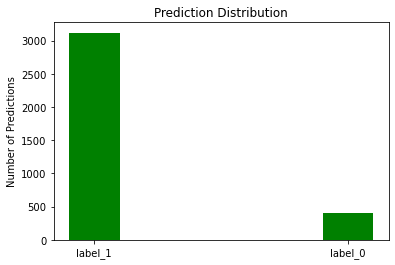

In [208]:
# visualize the prediction result

x, y = pred.columns, pred.iloc[0]
plt.bar(x, y, width = 0.2, color = 'green')
plt.title('Prediction Distribution')
plt.ylabel('Number of Predictions')
plt.show()